<a href="https://colab.research.google.com/github/vitaltavares/MQP2019/blob/master/Vital/Restructure_w_Implied_Vol_Smile%20v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BSM formula

## Abstract

- create GBM class
- define a method for BSM formula for a given option type

## Analysis

BS model assumes the distribution of stock as lognormal. In particular, it writes 
$$\ln \frac{S(T)}{S(0)} \sim \mathcal N((r  - \frac 1 2 \sigma^2) T, \sigma^2 T)$$
with respect to risk neutral measure. In the above, the parameters stand for

* $S(0)$: The initial stock price
* $S(T)$: The stock price at $T$
* $r$: interest rate
* $\sigma$: volatility




The call and put price with t $T$ and $K$ will be known as $C_0$ and $P_0$ given as below:
$$C_0 = \mathbb E [e^{-rT} (S(T) - K)^+] = S_0  \Phi(d_1) - K e^{-rT} \Phi(d_2),$$
and 
$$P_0 = \mathbb E [e^{-rT} (S(T) - K)^-] = K e^{-rT} \Phi(- d_2) - S_0  \Phi(- d_1),$$
where $d_i$ are given as
$$d_1 = \frac{1}{\sigma\sqrt{\left( T - t \right)}}
        \left[
          \ln\frac{S_{0}}{K}
          +
          \left(
            r + \frac{\sigma^2}{2}
          \right)
          \left(
            T-t
          \right)
        \right],$$
and
$$d_2 = \frac{1}{\sigma\sqrt{\left( T - t \right)}}
        \left[
          \ln\frac{S_{0}}{K}
          +
          \left(
            r - \frac{\sigma^2}{2}
          \right)
          \left(
            T-t
          \right)
        \right] = d_{1}-\sigma\sqrt{\left( T - t \right)}$$

From $\textit{Stochastic Calculus for Finance II Continuous Time Models}$ by Shreve


Put-call parity will be useful:
    $$C_0 - P_0 =  S(0) - e^{-rT} K.$$


## Code

In [0]:
import numpy as np
import scipy.stats as ss
from scipy.optimize import brentq
import matplotlib.pyplot as plt


We reload the european option class created before.

In [0]:

class VanillaOption:
  
  """
  :param S: underlying
  :param K: strike price
  :param r: rate
  :param t: time to expiration
  :param vol: volatility

  """

  def __init__(self,S,K,t,r, vol,otype = 1): 
    self.otype = otype
    self.K = K
    self.S = S
    self.t = t
    self.r = r
    self.vol = vol
  

  
  def payoff(self, S): #S: excercise price
    otype = self.otype
    S = self.strike
    K = self.K
    t = self.t

    return np.max([0, (S - K)*otype])
  
  def bsm_price(self):
    otype = self.otype
    S = self.S
    K = self.K
    t = self.t
    vol = self.vol
    r = self.r

    d1 = 1/(vol * np.sqrt(t))*(np.log(S/K) + (r + np.power(vol,2)/2)*(t)) # Need to be working with t minus current time t
    d2 = d1 - (vol * np.sqrt(t)) #  But how do we get the current time t
    
    return (otype * S * ss.norm.cdf(otype * d1) - otype * K * np.exp(-r * t) * ss.norm.cdf(otype * d2))
  
  
  def delta(self):
    otype = self.otype
    t = self.t
    k = self.K
    S = self.S
    vol = self.vol
    r = self.r
    
    d1 = 1/(vol*np.sqrt(t))*(np.log(S/k) + (r + np.power(vol,2)/2)*(t))
    
    if otype == 1:
      return ss.norm.cdf(d1)
    else:
      return ss.norm.cdf(d1) - 1
               
    
  def gamma(self):
    otype = self.otype
    t = self.t
    k = self.K
    
    S = self.S
    vol = self.vol
    r = self.r

    d1 = 1/(vol*np.sqrt(t))*(np.log(S/k) + (r + np.power(vol,2)/2)*(t))
    
    return ss.norm.pdf(d1) / (S * vol * np.sqrt(t))
  
  
  def vega(self):
    otype = self.otype
    t = self.t
    k = self.K
    
    S = self.S
    vol = self.vol
    r = self.r
    
    d1 = 1/(vol*np.sqrt(t))*(np.log(S/k) + (r + np.power(vol,2)/2)*(t))
    
    return ss.norm.pdf(d1) * np.sqrt(t)* S/ 100.0
  
  
  def theta(self):
    otype = self.otype
    t = self.t
    k = self.K
    
    S = self.S
    vol = self.vol
    r = self.vol
  
    
    d1 = 1/(vol*np.sqrt(t))*(np.log(S/k) + (r + np.power(vol,2)/2)*(t))
    d2 = 1/(vol*np.sqrt(t))*(np.log(S/k) + (r - np.power(vol,2)/2)*(t))
    
    if otype == 1:
      return (-S * ss.norm.pdf(d1) * vol / (2 * np.sqrt(t))) - (r * k * np.exp(-r * t) * ss.norm.cdf(d2))
    else:
      return (-S * ss.norm.pdf(d1) * vol / (2 * np.sqrt(t))) + (r * k * np.exp(-r * t) * ss.norm.cdf(-d2))
    
    
  def rho(self):
    otype = self.otype
    t = self.t
    k = self.K
    
    S = self.S
    vol = self.vol
    r = self.r

    
    d2 = 1/(vol*np.sqrt(t))*(np.log(S/k) + (r - np.power(vol,2)/2)*(t))
    
    if otype == 1:
      return k * ss.norm.cdf(d2) * t * np.exp(-r * t)
    else:
      return -k * ss.norm.cdf(-d2) * t * np.exp(-r * t)

 

 



Next, we create the gbm class, which is 
determined by three parameters. We shall initialize it
as it  is created.

BSM formula is given by a method of Gbm class with an input of an option.

In [3]:
'''===============
Test bsm_price
================='''

# At the money option w/ 6 months to expiry
option1 = VanillaOption(S= 100, K=100, t = 0.5, vol = 0.217, r = 0.019)
print('>>>>>>>>>>call value is ' + str(option1.bsm_price()))
option2 = VanillaOption(S= 100, K=100, t = 0.5, vol = 0.217, r = 0.019, otype=-1)
print('>>>>>>>>>>put value is ' + str(option2.bsm_price()))

>>>>>>>>>>call value is 6.570935681182348
>>>>>>>>>>put value is 5.625433925472393


In [4]:
'''===============
Test Arbitrage Free Model
================='''

#Delta
call_delta = option1.delta()
put_delta = option2.delta()
print(">>>>>>The Call Delta is " + str(call_delta))
print(">>>>>>The Put Delta is " + str(put_delta))

#Gamma
option_gamma = option1.gamma()
print(">>>>>>The Option's Gamma is " + str(option_gamma))

#Vega
option_vega = option1.vega()
print(">>>>>>The Option's Vega is " + str(option_vega))

#Theta
call_theta = option1.theta()
put_theta = option2.theta()
print(">>>>>>The Call Theta is " + str(call_theta))
print(">>>>>>The Put Theta is " + str(put_theta))

#Rho
call_rho = option1.rho()
put_rho = option2.rho()
print(">>>>>>The Call Rho is " + str(call_rho))
print(">>>>>>The Put Rho is " + str(put_rho))


>>>>>>The Call Delta is 0.5551301787716723
>>>>>>The Put Delta is -0.44486982122832774
>>>>>>The Option's Gamma is 0.02575087042678005
>>>>>>The Option's Vega is 0.27939694413056354
>>>>>>The Call Theta is -18.827102541462136
>>>>>>The Put Theta is 0.6416794760661366
>>>>>>The Call Rho is 24.471041097992444
>>>>>>The Put Rho is -25.05620802415258


In [0]:
###############
# Arbitrage-Free Model Object-Oriented
#############
class ArbitrageFree:
  def pc_parity(self, call_option, put_option):
    call_price = call_option.bsm_price()
    put_price = put_option.bsm_price()
    k = call_option.K  #Note: Put and Call with same strike k
    r = call_option.r     #and interest r
    t = call_option.t #and t
    s = call_option.S

    #give some space for machine precision error
    if call_price - put_price + np.exp(-r*t) - s<= 10^(-10): 
      return ">>>>>>>>>Option is arbitrage-free"
    else:
      return ">>>>>>>>>Option is not arbitrage-free"
  
  
  

In [6]:
'''===============
Test Arbitrage Free
================='''

arbFree = ArbitrageFree()
arbFree.pc_parity(option1,option2)

'>>>>>>>>>Option is arbitrage-free'

In [0]:
class ImpliedVolatility:
  def newtonImpliedVolCalc(self, vanillaoption, marketprice):
    otype = vanillaoption.otype
    t = vanillaoption.t
    K=vanillaoption.K

    r = vanillaoption.r
    vol = vanillaoption.vol
    S = vanillaoption.S
  

    tolerance = 0.000001
    x0 = vol
    xnew  = x0
    xold = x0 - 1
    
    while abs(xnew - xold) > tolerance:
      d1 = 1/(xnew*np.sqrt(t))*(np.log(S/K) + (r + np.power(xnew,2)/2)*(t))
      d2 = d1 - (xnew*np.sqrt(t))
      optionprice = otype * S * ss.norm.cdf(otype * d1) - otype * K * np.exp(-r * t) * ss.norm.cdf(otype * d2)
      vega = ss.norm.pdf(d1) * np.sqrt(t)* S/ 100.0
      xold = xnew
      xnew = xnew - ((optionprice - marketprice) / (vega))
      return abs(xnew)

In [33]:
impliedVol = ImpliedVolatility()

call_implied_vol = impliedVol.newtonImpliedVolCalc(option1,6.5706)
print("Call implied vol is", call_implied_vol)
put_implied_vol = impliedVol.newtonImpliedVolCalc(option2, 5.6254)
print("Put implied vol is",put_implied_vol)

6.570935681182348
0.27939694413056354
Call implied vol is 0.21579855098847597
5.625433925472393
0.27939694413056354
Put implied vol is 0.21687857607928146


In [38]:
marketpriceCall = 6.57
marketpricePut = 5.62


impliedVolCallArray = []
x_call_array = []
for i in range(int(100*(marketpriceCall-3.0)), int(100*(marketpricePut+3.0)), 1):
  k = i * (0.01)
  x_call_array.append(k)
  impliedVolCallArray.append(impliedVol.newtonImpliedVolCalc(option1, k))

impliedVolPutArray = []
x_put_array = []
for i in range(int(100*(marketpricePut-3.0)), int(100*(marketpricePut+3.0)), 1):
  k = float(i) * (0.01)
  x_put_array.append(k)
  impliedVolPutArray.append(impliedVol.newtonImpliedVolCalc(option2, k))

print(impliedVolCallArray)
print(impliedVolPutArray)

6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.570935681182348
0.27939694413056354
6.5709356811

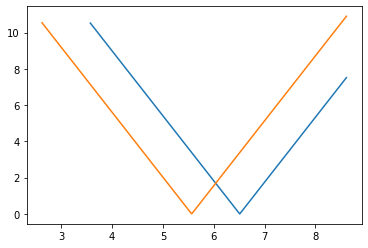

In [39]:
plt.plot(x_call_array, impliedVolCallArray)
plt.plot(x_put_array, impliedVolPutArray)